In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
interactions = pd.read_csv("../data/synthetic_interactions.csv")
videos = pd.read_csv("../data/video.csv")

In [3]:
print(interactions.head())
print(videos.head())

   user_id                          video_id user_interests  watch_ratio  \
0        1  666b6aeb26d2715177ba7dd2d5230d61         Gaming         0.10   
1        1  4f3eab1c62f4184a6965edc95d38c1c7         Gaming         0.30   
2        1  075ecd26abf8f920dc30a3da81c616f8         Gaming         0.26   
3        1  325dc90fcdf7f8123fabb09ebed208e8         Gaming         0.18   
4        1  ebd9140ae94ba6daf33e189c3ccb4328         Gaming         0.03   

   watch_time  liked  
0        2.84      0  
1        3.88      0  
2        9.63      0  
3        4.64      0  
4        0.81      0  
                             row_id                         title  \
0  94d9662e9a3cb3c97fab4e9de4cdd88c  Pro Tips for Fortnite in 60s   
1  113a021d1d908fa091eec348ef9e4398         Night Routine  Summer   
2  6386b7d6a9b234fd4677a4839a275d00    Morning Routine  Beginners   
3  c137c7a68c9f5fc3e656b2198527639c               Perfect  Cover    
4  ca81fcf65519182a38438938fde0447e   Best Settings for EA F

In [4]:
#Verify Minimum Requirements
num_users = interactions["user_id"].nunique()
num_items = videos["row_id"].nunique()
num_interactions = len(interactions)

print("Users:", num_users)
print("Items:", num_items)
print("Interactions:", num_interactions)

Users: 6000
Items: 1000
Interactions: 53944


In [5]:
#No Missing IDs
print(interactions[["user_id", "video_id"]].isnull().sum())

user_id     0
video_id    0
dtype: int64


In [ ]:
#Handle Missing Values
missing_interactions = interactions.isnull().sum()
missing_videos = videos.isnull().sum()
missing_interactions.to_csv("../results/Part_1/missing_values_interactions.csv")
missing_videos.to_csv("../results/Part_1/missing_values_videos.csv")

In [7]:
#2.2.2 Handle duplicates 
interactions_clean = interactions.drop_duplicates(subset=["user_id", "video_id"])
videos_clean = videos.drop_duplicates(subset=["row_id"])

In [11]:
def calculate_weighted_rating(row):
    # 1. Normalize watch ratio (cap at 1.0 to preserve the 80/20 weight balance)
    norm_watch = min(row['watch_ratio'], 1.0)
    
    # 2. Calculate weighted score (0.0 to 1.0)
    # 80% on watch, 20% on liked
    score = (0.8 * norm_watch) + (0.2 * row['liked'])
    
    # 3. Scale to 1-5 range
    rating = 1 + (4 * score)
    
    # 4. Round to nearest 0.5 and clip
    rating = round(rating * 2) / 2
    return float(min(5.0, max(1.0, rating)))

# Apply the transformation
interactions_clean['rating'] = interactions_clean.apply(calculate_weighted_rating, axis=1)

# Save the final dataset
interactions_clean.to_csv("../results/Part_1/interactions_clean.csv", index=False)

#### Extract basic statistics: Number of users, items, ratings. Sparsity level and rating distribution 


Basic Dataset Statistics
------------------------
Number of users   : 6000
Number of items   : 1000
Number of ratings : 53944
Sparsity level    : 0.9910

Rating Distribution
-------------------
rating
1.0     8555
1.5    20756
2.0     8341
2.5     2482
3.0     2654
3.5     2761
4.0     3437
4.5     1892
5.0     3066
Name: count, dtype: int64


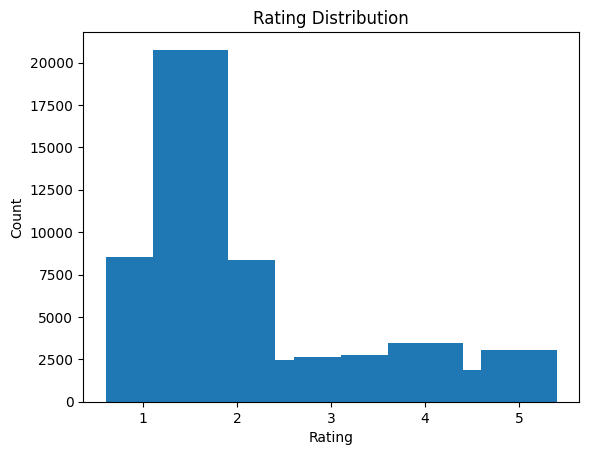

In [12]:
# Basic Statistics

num_users = interactions_clean["user_id"].nunique()
num_items = interactions_clean["video_id"].nunique()
num_ratings = len(interactions_clean)

# Sparsity calculation
sparsity = 1 - (num_ratings / (num_users * num_items))

print("Basic Dataset Statistics")
print("------------------------")
print(f"Number of users   : {num_users}")
print(f"Number of items   : {num_items}")
print(f"Number of ratings : {num_ratings}")
print(f"Sparsity level    : {sparsity:.4f}")


# Rating Distribution

rating_distribution = (
    interactions_clean["rating"]
    .value_counts()
    .sort_index()
)

print("\nRating Distribution")
print("-------------------")
print(rating_distribution)

plt.figure()
plt.bar(rating_distribution.index, rating_distribution.values)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Distribution")
plt.show()



#### 2.3. Basic Exploratory Analysis

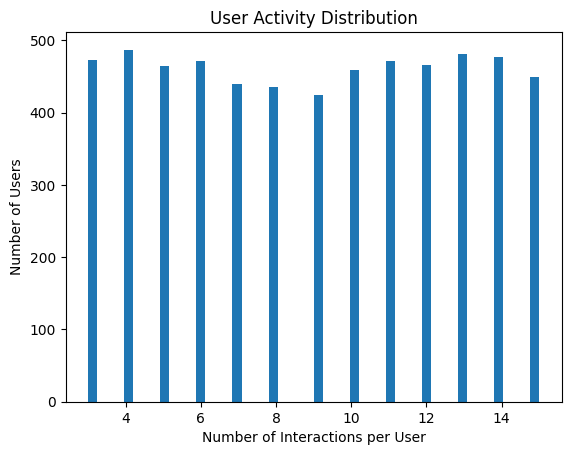

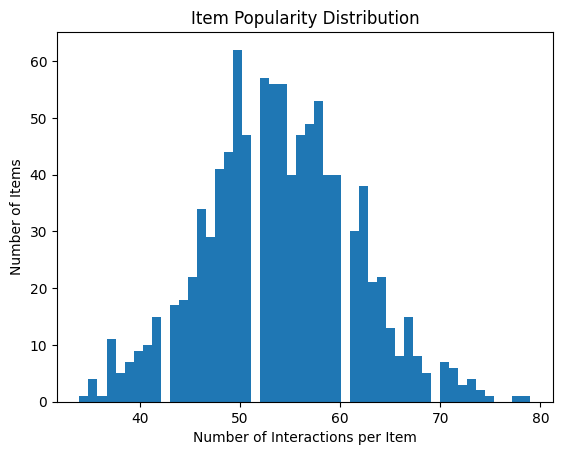

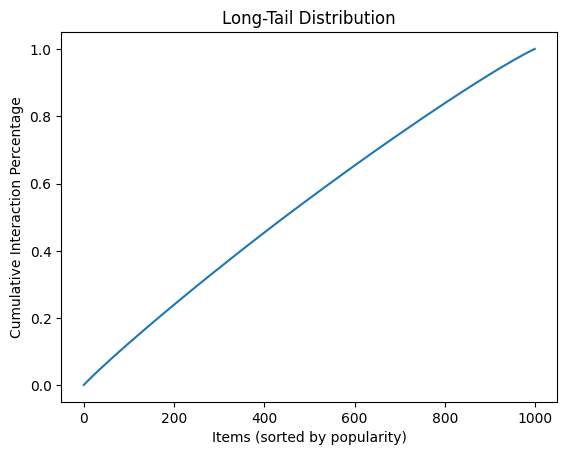

In [13]:
#User Activity Distribution
user_activity = (
    interactions_clean
    .groupby("user_id")
    .size()
)

plt.figure()
plt.hist(user_activity.values, bins=50)
plt.xlabel("Number of Interactions per User")
plt.ylabel("Number of Users")
plt.title("User Activity Distribution")
plt.show()

#item popularity distribution.
item_popularity = (
    interactions_clean
    .groupby("video_id")
    .size()
)

plt.figure()
plt.hist(item_popularity.values, bins=50)
plt.xlabel("Number of Interactions per Item")
plt.ylabel("Number of Items")
plt.title("Item Popularity Distribution")
plt.show()

#Long-Tail Identification
item_popularity_sorted = item_popularity.sort_values(ascending=False)
cumulative_percentage = (
    item_popularity_sorted.cumsum()
    / item_popularity_sorted.sum()
)

plt.figure()
plt.plot(cumulative_percentage.values)
plt.xlabel("Items (sorted by popularity)")
plt.ylabel("Cumulative Interaction Percentage")
plt.title("Long-Tail Distribution")
plt.show()




In [14]:
#calculates how much of the total interactions are accounted for by the top 10% most popular items
top_10_percent = int(0.1 * len(item_popularity_sorted))

top_interactions = item_popularity_sorted.iloc[:top_10_percent].sum()
total_interactions = item_popularity_sorted.sum()

print("Top 10% items account for:",
      top_interactions / total_interactions)


Top 10% items account for: 0.12477754708586683
